In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

In [2]:
from transformers import set_seed

In [3]:
set_seed(0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Model

In [5]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
corr = 0.25
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

# Load Dataset and Create Environment

In [6]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [12]:
trajs = []
for traj in eval_trajs:
    _traj = torch.FloatTensor(traj['context_states']).to(device)
    _traj = _traj[:1000]
    trajs.append(_traj)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CPCModel(nn.Module):
    def __init__(self, input_dim, encoding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.LayerNorm(encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.LayerNorm(encoding_dim)
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        encoded = self.encoder(x)  # (batch_size, seq_len, encoding_dim)
        return encoded

In [14]:
def train_cpc(
        model, trajs,
        n_epochs=100, lr=1e-3,
        n_prediction_steps=10, neg_weight=1,
        print_losses=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    n_prediction_steps = 10
    
    for epoch in range(n_epochs):
        traj = trajs[epoch % len(trajs)]

        optimizer.zero_grad()
        encoded = model(traj)

        total_loss = 0
        # Compute loss for different time offsets
        for k in range(1, n_prediction_steps + 1):
            # Positive samples: pairs that are k steps apart
            pos = (encoded[k:] * encoded[:-k]).sum(dim=-1)
            
            # Negative samples: all other pairs at k steps apart
            neg = torch.matmul(encoded[k:], encoded[:-k].T).squeeze()
            
            # Compute NCE loss for this time offset
            step_loss = (-pos + neg_weight * torch.logsumexp(neg, dim=-1)).mean()
            total_loss += step_loss / n_prediction_steps
        
        total_loss.backward()
        optimizer.step()
        
        loss_val = total_loss.item()
        if print_losses and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss_val:.4f}")
        train_losses.append(loss_val)

    return train_losses

In [15]:
# Create and train the model
input_dim = traj['context_states'].shape[-1]  # Should be 10 based on your env config

In [57]:
model = CPCModel(input_dim=input_dim, encoding_dim=512).to(device)
train_losses = train_cpc(
    model, trajs, n_epochs=2000, lr=1e-3,
    n_prediction_steps=10, neg_weight=1)

Epoch 10, Loss: 6.7782
Epoch 20, Loss: 6.6448
Epoch 30, Loss: 6.5952
Epoch 40, Loss: 6.5545
Epoch 50, Loss: 6.6890
Epoch 60, Loss: 6.6852
Epoch 70, Loss: 6.6286
Epoch 80, Loss: 6.5899
Epoch 90, Loss: 6.5551
Epoch 100, Loss: 6.6786
Epoch 110, Loss: 6.6789
Epoch 120, Loss: 6.6278
Epoch 130, Loss: 6.5850
Epoch 140, Loss: 6.5500
Epoch 150, Loss: 6.6743
Epoch 160, Loss: 6.6726
Epoch 170, Loss: 6.6269
Epoch 180, Loss: 6.5802
Epoch 190, Loss: 6.5456
Epoch 200, Loss: 6.6698
Epoch 210, Loss: 6.6660
Epoch 220, Loss: 6.6238
Epoch 230, Loss: 6.5739
Epoch 240, Loss: 6.5410
Epoch 250, Loss: 6.6652
Epoch 260, Loss: 6.6593
Epoch 270, Loss: 6.6193
Epoch 280, Loss: 6.5667
Epoch 290, Loss: 6.5366
Epoch 300, Loss: 6.6606
Epoch 310, Loss: 6.6526
Epoch 320, Loss: 6.6129
Epoch 330, Loss: 6.5585
Epoch 340, Loss: 6.5312
Epoch 350, Loss: 6.6553
Epoch 360, Loss: 6.6457
Epoch 370, Loss: 6.6047
Epoch 380, Loss: 6.5500
Epoch 390, Loss: 6.5260
Epoch 400, Loss: 6.6494
Epoch 410, Loss: 6.6383
Epoch 420, Loss: 6.5945
E

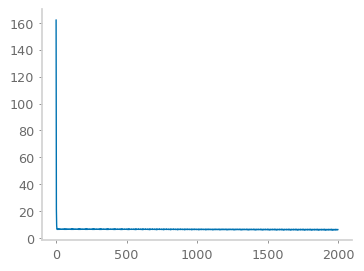

In [58]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses)
plt.show()


# Does Kernel Alignment still look fine?

In [44]:
i_eval = 3
traj = eval_trajs[i_eval]
env_config = {
    'max_layers': 7,
    'horizon': 1600,
    'branching_prob': 1.0,
    'node_encoding_corr': corr,
    'state_dim': 10,
    'initialization_seed': np.array(traj['initialization_seed']).item()
}
env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)

In [45]:
def get_kernel_alignment(K_A, K_B):
    """ Centered Kernel Alignment """
    n = K_A.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    K_A_centered = H @ K_A @ H
    K_B_centered = H @ K_B @ H
    
    # Compute alignment using Frobenius norm
    numerator = np.sum(K_A_centered * K_B_centered)
    denominator = np.sqrt(np.sum(K_A_centered * K_A_centered) * np.sum(K_B_centered * K_B_centered))
    
    return numerator / denominator if denominator != 0 else 0

In [46]:
layers = []
positions = []
state_features = []
state_features = list(env.node_map.keys())

for state_feature in state_features:
    layers.append(env.node_map[state_feature].layer)
    positions.append(env.node_map[state_feature].pos)

In [47]:
true_dist_matrix = []

for state_feature in state_features:
    _, dist_from_state = env._make_opt_action_dict(state_feature)
    sorted_dist_from_state = []
    for state_feature in state_features:
        sorted_dist_from_state.append(dist_from_state[state_feature])
    true_dist_matrix.append(sorted_dist_from_state)

true_dist_matrix = np.array(true_dist_matrix)


In [48]:
def run_model(model, state_features):
    hidden_states = []
    for state in state_features:
        # Create a sequence with just the single state repeated
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)  # Add batch and sequence dims
        
        # Get model representations
        with torch.no_grad():
            encoded = model.encoder(state_tensor.to(device))
            hidden_states.append(encoded.squeeze().detach().cpu().numpy())
    
    return hidden_states

In [50]:
kas = []
gammas = np.arange(0.1, 1.0, 0.1)
hidden_states = run_model(model, state_features)
data = np.stack(hidden_states)
data -= data.mean(0)[None,:]
for gamma in gammas:
    K_input = gamma ** true_dist_matrix # exponential kernel
    K_latents = data @ data.T
    kernel_alignment = get_kernel_alignment(K_input, K_latents)
    kas.append(kernel_alignment)

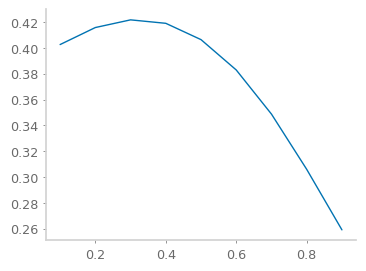

In [51]:
plt.figure(figsize=(4, 3))
plt.plot(gammas, kas)
plt.show()

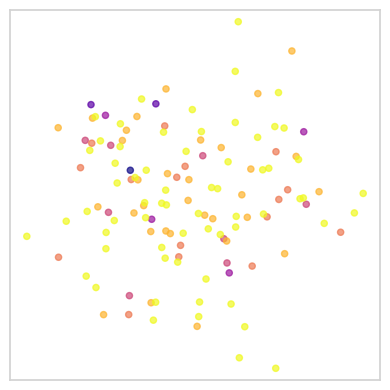

In [52]:
fig, ax = plt.subplots(figsize=(4, 4))
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
data_pca = data_pca / np.abs(data_pca).max(axis=0)
# Plot the PCA results
ax.scatter(
   data_pca[:, 0], data_pca[:, 1],
   c=layers, cmap='plasma', s=20,
   alpha=0.7)
ax.set_aspect('equal', 'box')
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])
# Add box outline on all sides
for spine in ax.spines.values():
    spine.set_visible(True)
plt.tight_layout()
plt.show()


# Test for factorized representation

In [53]:
def get_responses(i_eval):
    traj = eval_trajs[i_eval]
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding_corr': corr,
        'state_dim': 10,
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)

    layers = []
    positions = []
    nodes = []
    state_features = []
    state_features = list(env.node_map.keys())
    
    for state_feature in state_features:
        l = env.node_map[state_feature].layer
        p = env.node_map[state_feature].pos
        layers.append(l)
        positions.append(p)
        nodes.append((l, p))

    hidden_states = run_model(model, state_features)
    return nodes, hidden_states

In [54]:
results = {
    'nodes': [],
    'hidden_states': []
}

for i_eval in range(n_eval_envs):
    nodes, hidden_states = get_responses(i_eval)
    results['nodes'].extend(nodes)
    results['hidden_states'].extend(hidden_states)

In [55]:
df = pd.DataFrame(results)

same_node = {
    'sim': [],
    'comparison_node_layer': []
}
diff_node = {
    'sim': [],
    'comparison_node_layer': []
}


for node in df['nodes'].unique():
    node_df = df[df['nodes'] == node]
    other_node_df = df[df['nodes'] != node]
    node_hidden_states = np.stack(node_df['hidden_states'].to_numpy())
    other_node_hidden_states = np.stack(other_node_df['hidden_states'].to_numpy())
    n_same_node = node_hidden_states.shape[0]
    stacked_reprs = np.vstack((node_hidden_states, other_node_hidden_states))
    cc = np.corrcoef(stacked_reprs)
    for i in range(n_same_node):
        for j in range(i+1, n_same_node):
            same_node['sim'].append(cc[i, j])
            same_node['comparison_node_layer'].append(int(node[1]))
    for i in range(n_same_node):
        for j in range(i+1, n_same_node):
            _j = j + n_same_node
            diff_node['sim'].append(cc[i, _j])
            diff_node['comparison_node_layer'].append(int(node[1]))

In [56]:
print(np.mean(same_node['sim']))
print(np.std(same_node['sim']))
print()
print(np.mean(diff_node['sim']))
print(np.std(diff_node['sim']))

0.9865209078439029
0.0036097787387350463

0.9868066118848815
0.0035289200946799436
